# Упражнение 2.2
Этот элемент курса оценивается как 'Упражнение 2'  
вес: 1.0

## Задание
Ехала машина по одной тихой английской дороге. На дороге была нанесена разделительная полоса, которая была то прерывистой, то сплошной, то двойной сплошной. В нашем распоряжении есть условные координаты разделительной полосы ([исходные данные](./data/car231.csv)), нанесенной на эту дорогу. Наша машина очень спешила, обгоняла другие машины, выезжая порой на встречную полосу. Все движения машины фиксировались в тех же условных координатах, правда, иногда датчик в машине давал сбои, передавая совсем неправильные координаты. Надо определить, сколько раз машина пересекала разделительную полосу каждого типа. Для этого надо проанализировать движение машины, убрать выбросы, заполнить образовавшиеся пропущенные значения, усредняя соседние координаты (по 1 координате в каждую сторону). Потом надо построить график дороги и график движения автомобиля. Чтобы на графике дороги было видно, где какая разделительная полоса, данные можно, например, разделить на несколько рядов – один для прерывистой линии, второй для сплошной, третий для двойной сплошной.

Тогда можно будет сосчитать, сколько раз автомобиль пересек разделительную линию каждого типа. С примером решения Вы можете ознакомиться в этом [файле](./data/Lec2ex2.pdf).

In [135]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [136]:
df = pd.read_csv('./data/car231.csv')
# df.info()
df

,LINE_TYPE,LINE,CAR
0,SINGLE,500,490
1,SINGLE,500,490
2,SINGLE,500,490
3,SINGLE,500,490
4,SINGLE,500,490
...,...,...,...
495,DOUBLE,130,120
496,DOUBLE,131,121
497,DOUBLE,132,122
498,DOUBLE,133,123


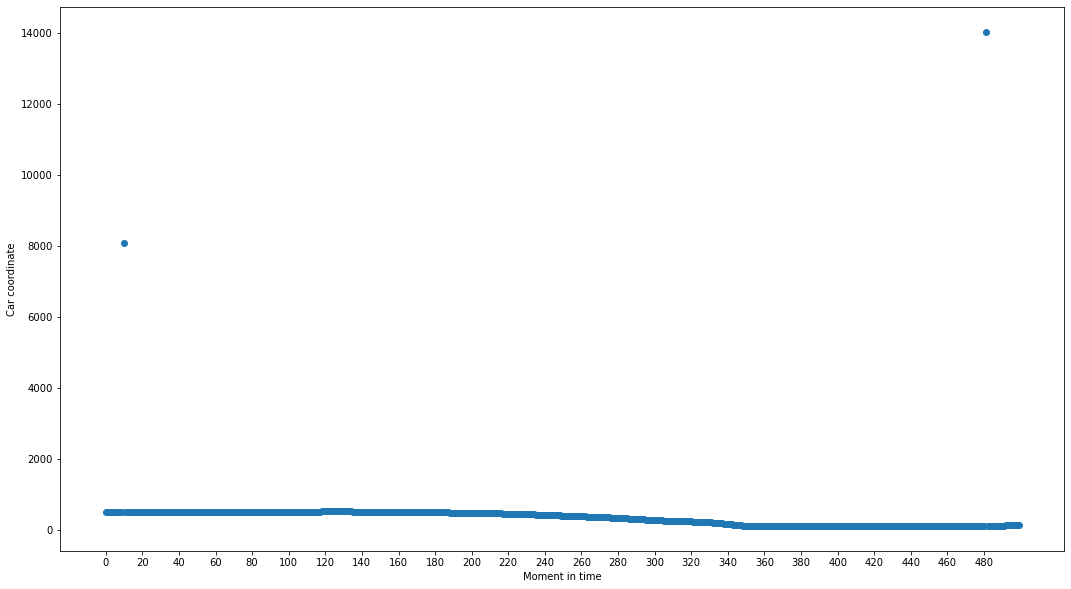

In [137]:
# Visualize initial data
plt.figure(figsize=(18,10))
plt.scatter(np.arange(0, df['CAR'].size, 1), df['CAR'])
plt.xlabel('Moment in time')
plt.ylabel('Car coordinate')
plt.xticks(np.arange(0, df['CAR'].size, 20), np.arange(0, df['CAR'].size, 20))
plt.show()

Finding the outliers using IQR (Inter Quartile Range). IQR tells how spread the middle values are.  It can be used to tell when a value is too far from the middle.  
An outlier is a point which falls more than 1.5 times the interquartile range above the third quartile or below the first quartile.

In [138]:
df_s = df['CAR'].copy().values

# Arranging data in increasing order
df_s.sort()

# Calculating first(Q1) and third quartile(Q3)
Q1, Q3 = np.percentile(df_s, [25,75])

# Finding interquartile range (q3-q1)
IQR = Q3 - Q1

# Finding lower bound Q1*1.5
lower_bound = Q1 - (1.5 * IQR) 

# Finding upper bound Q3*1.5
upper_bound = Q3 + (1.5 * IQR)

print('Lower bound:', lower_bound)
print('Upper bound:', upper_bound)

Lower bound: -486.0
Upper bound: 1082.0


In [139]:
# Anything that lies outside of lower and upper bound is an outlier
outliers_upper_idxs = np.where(df['CAR'] >= upper_bound)[0]
outliers_lower_idxs = np.where(df['CAR'] <= lower_bound)[0]

print('Outliers upper indexes:', outliers_upper_idxs)
print('Outliers lower indexes:', outliers_lower_idxs)

Outliers upper indexes: [ 10 481]
Outliers lower indexes: []


In [140]:
outliers_idxs = list(outliers_upper_idxs) + list(outliers_lower_idxs)
print(outliers_idxs)

[10, 481]


In [141]:
# If outliers either have index 0 or max size of array, then delete them,
# otherwise replace outliers by the mean of two neighbouring values.
if outliers_upper_idxs.size > 0:
    for idx in outliers_upper_idxs:
        if idx != 0 and idx != (df['CAR'].size-1):
            print('before normalizing:', df['CAR'][idx])
            df.loc[idx, 'CAR'] = (df['CAR'][idx-1] + df['CAR'][idx+1]) // 2
            print('after normalizing', df['CAR'][idx])
        else:
            df.drop(index=[idx], inplace=True)

before normalizing: 8071
after normalizing 491
before normalizing: 14029
after normalizing 106


In [142]:
line_single = df['LINE'].where(df['LINE_TYPE'] == 'SINGLE')
line_interrupt = df['LINE'].where(df['LINE_TYPE'] == 'INTERRUPT')
line_double = df['LINE'].where(df['LINE_TYPE'] == 'DOUBLE')

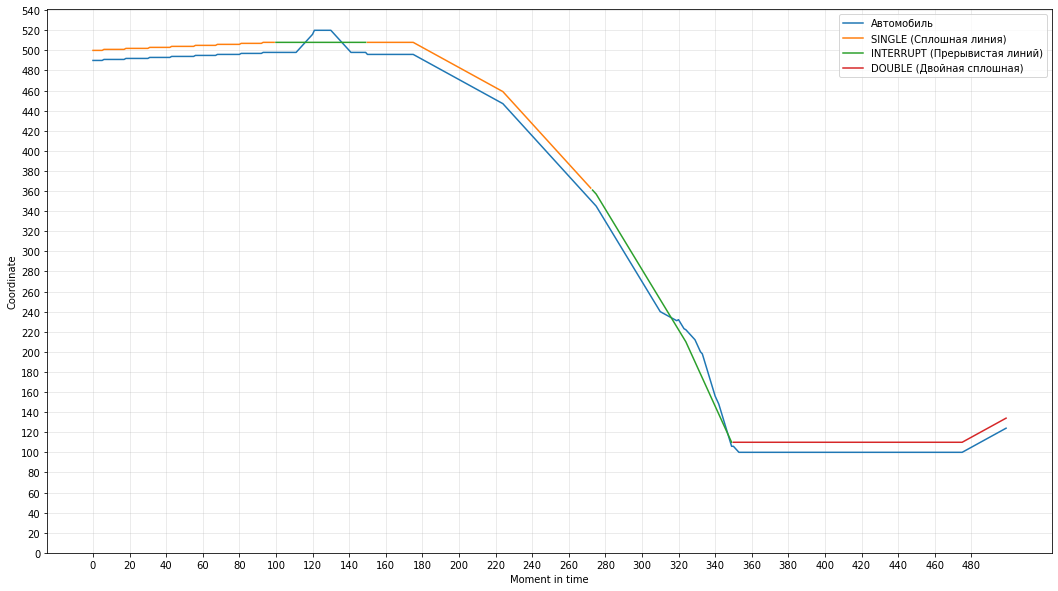

In [143]:
plt.figure(figsize=(18,10))
plt.plot(np.arange(0, df['CAR'].size, 1), df['CAR'], label='Автомобиль')
plt.plot(line_single, label='SINGLE (Сплошная линия)')
plt.plot(line_interrupt, label='INTERRUPT (Прерывистая линий)')
plt.plot(line_double, label='DOUBLE (Двойная сплошная)')
plt.legend(loc='best')
plt.xlabel('Moment in time')
plt.ylabel('Coordinate')
plt.grid(linewidth=0.5, alpha=0.5)
plt.xticks(np.arange(0, df['CAR'].size, 20), np.arange(0, df['CAR'].size, 20))
plt.yticks(np.arange(0, df.shape[0]+41, 20), np.arange(0, df.shape[0]+41, 20))
plt.show()

In [144]:
# Each list contain coordinates where car intersects the line
intersections_single = []
intersections_interrupt = []
intersections_double = []

In [145]:
for index, row in df.iterrows():
    if index == 0:
        continue
    else:
        # Detect intersection
        if df['CAR'][index] >= df['LINE'][index] and df['CAR'][index-1] < df['LINE'][index-1] \
        or df['CAR'][index] <= df['LINE'][index] and df['CAR'][index-1] > df['LINE'][index-1]:
            if df['LINE_TYPE'][index] == 'SINGLE':
                intersections_single.append(df['CAR'][index])
            elif df['LINE_TYPE'][index] == 'INTERRUPT':
                intersections_interrupt.append(df['CAR'][index])
            elif df['LINE_TYPE'][index] == 'DOUBLE':
                intersections_double.append(df['CAR'][index])

#### Кол-во пересечений SINGLE линии:

In [146]:
len(intersections_single)

0

#### Кол-во пересечений INTERRUPT линии:

In [147]:
len(intersections_interrupt)

4

#### Кол-во пересечений DOUBLE линии:

In [148]:
len(intersections_double)

0